In [1]:
# %% Import Libraries
#This is a test
import os
import pickle
import scipy.io
import numpy as np
import pandas as pd
import torch as tc
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import matplotlib.patches as mpatches
from tqdm import tqdm
from bptt.models import Model
import model_anafunctions as func

from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.rcParams['font.size'] = 20

numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


In [2]:
#%% FUNCTIONS
def Hyper_mod(mpath,data_path):
    file=open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),'rb')
    hyper=pickle.load(file)
    file.close()
    hyper['data_path']=os.path.join(data_path,'Training_data.npy').replace('\\','/')
    hyper['inputs_path']=os.path.join(data_path,'Training_inputs.npy').replace('\\','/')
    hyper['device_id'] = 0
    full_name = open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),"wb")                      # Name for training data
    pickle.dump(hyper,full_name)            # Save train data
    #close save instance 
    full_name.close()

def Classifier_events(X_data,X_dataT,X_model,X_modelT,Event,Trainexp,Testexp):
    # Train classifier with training data
    ND_train = Event[Trainexp]
    ND_test = Event[Testexp]

    #%% Next Decisions
    score_data=[]
    score_model=[]
    score_modelSh=[]
    score_dataSh=[]

    clf = LinearDiscriminantAnalysis()
    for i in range(1000):
        # Classifying data
        X_train=X_data
        y_train=ND_train
        X_test = X_dataT
        y_test = ND_test
        clf.fit(X_train,y_train)
        score_data.append(clf.score(X_test,y_test))

        # Classifying data Shuffle
        list_trials=np.linspace(0,X_data.shape[0]-1,X_data.shape[0]).astype(int)
        np.random.shuffle(list_trials)
        y=ND_train[list_trials]
        random_state=0
        X_trainS, X_testS, y_trainS, y_testS = train_test_split(
            X_train, y, test_size=0.2, stratify=y, random_state=0
            )
        clf.fit(X_trainS,y_trainS)
        score_dataSh.append(clf.score(X_testS,y_testS))

        # Classifying model
        X_trainM=X_model
        y_trainM=ND_train
        X_testM = X_modelT
        y_testM = ND_test
        clf.fit(X_trainM,y_trainM)
        score_model.append(clf.score(X_testM,y_testM))
        
        # Classifying model Shuffle
        list_trials=np.linspace(0,X_data.shape[0]-1,X_data.shape[0]).astype(int)
        np.random.shuffle(list_trials)
        y=ND_train[list_trials]
        X_trainMS, X_testMS, y_trainMS, y_testMS = train_test_split(
            X_trainM, y, test_size=0.2, stratify=y, random_state=0
            )
        clf.fit(X_trainMS,y_trainMS)
        score_modelSh.append(clf.score(X_testMS,y_testMS))

    return np.array(score_data).mean(),np.array(score_dataSh).mean(),np.array(score_model).mean(),np.array(score_modelSh).mean()


def Plot_trace_example(Neuron_data,Model_data,Input_data,eneu): 
    ################################ Parameters to modify ################################ 
    # Plot properties
    # colors
    c_recorded_activity = 'black'                                   # Color for line: Recorded Activity 
    c_simulated_activity = 'red'                                    # Color for line: Simulated Activity
    c_stop = '#C13E71'                                              # Color for area: Wheel stop phase
    c_cue = '#71C13E'                                               # Color for area: Response phase
    c_gamble = '#3E71C1'                                            # Color for area: Gamble reward
    c_safe = '#C18E3E'                                              # Color for area: Safe reward
    alpha_value = 0.2                                               # Transparency level for sections of the trial (stop wheel, cue, reward g/s)
    #####################################################################################

    # Create subplots
    plt.rcParams['font.size'] = 18
    fig, axs = plt.subplots(1, 3, figsize=(22, 5))
    for ax,it in zip(axs,range(3)):
        # Creating x vector. (Time)
        vec_length = Neuron_data[it].shape[0]
        temp_vec = np.linspace(0,vec_length,vec_length)*0.02
        
        # Creating the areas for each trial
        #Wheel Stop
        #Sections Cue
        ini_stop = np.where(np.diff(Input_data[it][:,0])==1.)[0]-50
        end_stop = np.where(np.diff(Input_data[it][:,0])==1.)[0]
        stop_sections = [(ini_stop[i]*0.02,end_stop[i]*0.02) for i in range(len(ini_stop))]
        #Sections Cue
        ini_cue = np.where(np.diff(Input_data[it][:,0])==1.)[0]+1
        end_cue = np.where(np.diff(Input_data[it][:,0])==-1.)[0]+1
        cue_sections = [(ini_cue[i]*0.02,end_cue[i]*0.02) for i in range(len(ini_cue))]
        #Sections Reward Gamble
        ini_grew = np.where(np.diff(Input_data[it][:,1])==4.)[0]+1
        end_grew = np.where(np.diff(Input_data[it][:,1])==-4.)[0]+1+25
        grew_sections = [(ini_grew[i]*0.02,end_grew[i]*0.02) for i in range(len(ini_grew))]
        #Sections Reward Safe
        ini_srew = np.where(np.diff(Input_data[it][:,2])==1.)[0]+1
        end_srew = np.where(np.diff(Input_data[it][:,2])==-1.)[0]+1+25
        srew_sections = [(ini_srew[i]*0.02,end_srew[i]*0.02) for i in range(len(ini_srew))]

        # Ploting the data for each concatenated trial
        ax.plot(temp_vec,Neuron_data[it][:,eneu],color=c_recorded_activity, lw = 2,label="Recorded activity")
        ax.plot(temp_vec,Model_data[it][:,eneu],color=c_simulated_activity, lw = 2,label="Simulated activity")
        for section in stop_sections:
            start, end = section
            ax.add_patch(Rectangle((start, ax.get_ylim()[0]), end - start, ax.get_ylim()[1]-ax.get_ylim()[0], color=c_stop, alpha=alpha_value))
        for section in cue_sections:
            start, end = section
            ax.add_patch(Rectangle((start, ax.get_ylim()[0]), end - start, ax.get_ylim()[1]-ax.get_ylim()[0], color=c_cue, alpha=alpha_value))
        for section in grew_sections:
            start, end = section
            ax.add_patch(Rectangle((start, ax.get_ylim()[0]), end - start, ax.get_ylim()[1]-ax.get_ylim()[0], color=c_gamble, alpha=alpha_value))
        for section in srew_sections:
            start, end = section
            ax.add_patch(Rectangle((start, ax.get_ylim()[0]), end - start, ax.get_ylim()[1]-ax.get_ylim()[0], color=c_safe, alpha=alpha_value))
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Firing rate (norm.)")
    # Add legend outside the subplots
    handles, labels = axs[0].get_legend_handles_labels()
    rect_handles = [
        Line2D([0], [0], color=c_stop, alpha=alpha_value, lw=12, label='Stop'),
        Line2D([0], [0], color=c_cue, alpha=alpha_value, lw=12, label='Cue'),
        Line2D([0], [0], color=c_gamble, alpha=alpha_value, lw=12, label='Grew'),
        Line2D([0], [0], color=c_safe, alpha=alpha_value, lw=12, label='Srew')
    ]
    fig.legend(handles=handles + rect_handles, labels=labels + ['Wheel stop','Response phase','Gamble reward','Safe reward'], 
            loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=6, fontsize = 22)
    plt.tight_layout()


######################
def Classifier_Test_Sessions(data_path,mpath,behaviour_path,num_epochs):

    # Selection of the file
    os.chdir(behaviour_path)
    list_files = os.listdir(behaviour_path)
    for i in list_files:
        if i.find('Behaviour')>0:
            Behaviour_name = i

    # Load data
    # Open the Behaviour file
    Bdata = scipy.io.loadmat(Behaviour_name)
    BehData = Bdata[list(Bdata.keys())[-1]]

    # Next Decision (G,S)
    ND = (BehData[:,12]==1)*1+(BehData[:,12]==0)*0

    # Reward (Gamble, Safe, Nothing)
    RW = (BehData[:,12]==1)*(BehData[:,13])*2+(BehData[:,13])*(BehData[:,12]==0)*1

    # Blocks (High, Medium, Low)
    blocks=np.unique(BehData[:,5])
    if len(blocks)==3:
        B_se=(BehData[:,5]==blocks[0])*0+(BehData[:,5]==blocks[1])*1+(BehData[:,5]==blocks[2])*2
    elif len(blocks)==2:
        B_se=(BehData[:,5]==blocks[0])*0+(BehData[:,5]==blocks[1])*1
    elif len(blocks)<2:
        print("There is no different blocks to classify the data")
    else:
        print("This is not the original task")

    train_n,train_i = func.load_data(data_path,'Training')

    Hyper_mod(mpath,data_path)

    # Loading Model
    m = Model()
    m.init_from_model_path(mpath, epoch=num_epochs)
    m.eval()

    # Generation Training Data
    ModelS=[]
    for w_index in tqdm(range(len(train_n))):
        data_trial=tc.from_numpy(train_n[w_index]).float()          # tensor of neuronal data for initial trial data
        input_trial = tc.from_numpy(train_i[w_index]).float()
        length_sim = input_trial.shape[0]
        X, _ = m.generate_free_trajectory(data_trial,input_trial,length_sim,w_index)
        ModelS.append(X[:,:])

    # Concatenating signals
    Nseries,_=func.concatenate_list(train_n,0)          # recorded activity
    Iseries,_=func.concatenate_list(train_i,0)          # external input
    Mseries,_=func.concatenate_list(ModelS,0)           # simulated activity


    # Second point:
    # Load Metadata
    file=open(os.path.join(data_path,'Metadata.pkl'),'rb')
    Metadata=pickle.load(file)
    file.close()

    test_n,test_i = func.load_data(data_path,'Test')

    # Obtaining the original data for test trials and geneterate test trials by the model
    _, W1t, W2t, _, _, Ct = m.get_latent_parameters()

    # Transform tensor to numpy format
    W2 = W2t.detach().numpy().transpose(1,2,0)
    W1 = W1t.detach().numpy().transpose(1,2,0)
    C = Ct.detach().numpy()
    # General Parameters
    num_neurons=train_n[0].shape[1]

    # Generate Latent states for Test Trials
    # Identificating Test Trials in the training trial set
    t_prev = [i for i in Metadata["Training2Test"]]
    t_post = [i+1 for i in Metadata["Training2Test"]]

    # Computing W matrices for test trials
    W2_test = np.empty((W2.shape[0],W2.shape[1],len(Metadata["TestTrials"])))
    W1_test = np.empty((W1.shape[0],W1.shape[1],len(Metadata["TestTrials"])))
    for i in range(len(t_prev)):
        W2_test[:,:,i] = (W2[:,:,t_prev[i]]+W2[:,:,t_post[i]])/2.0
        W1_test[:,:,i] = (W1[:,:,t_prev[i]]+W1[:,:,t_post[i]])/2.0
    #Generate Latent states
    ModelT = []

    #Generate Latent states
    W1_ind = [tc.from_numpy(W1_test[:,:,i]).float() for i in range(len(t_prev))]
    W2_ind = [tc.from_numpy(W2_test[:,:,i]).float() for i in range(len(t_prev))]
    for i in range(len(W1_ind)):
        data_test=tc.from_numpy(test_n[i]).float()
        input_test=tc.from_numpy(test_i[i]).float()
        T0=test_n[i].shape[0]
        X, _ = m.generate_test_trajectory(data_test[0:11,:],W2_ind[i],W1_ind[i],input_test, T0,i)
        ModelT.append(X)

    neuron_example = 36
    Plot_trace_example(test_n,ModelT,test_i,neuron_example)

    # Concatenating signals
    IseriesT,_=func.concatenate_list(test_i,0)          # external input
    MseriesT,_=func.concatenate_list(ModelT,0)           # simulated activity
    NseriesT,_=func.concatenate_list(test_n,0)

    Test_trials = Metadata["TestTrials"]; Training_trials = Metadata["TrainingTrials"]    
        
    itrain = 0
    itest = 0
    Trials_inmodel = []

    for i in range(len(Metadata["TestTrials"])+len(Metadata["TrainingTrials"])):
        if i in Metadata["TrainingTrials"]:
            Trials_inmodel.append(np.sum(np.diff(train_i[itrain][:,0])==1))
            itrain += 1
        elif i in Metadata["TestTrials"]:
            Trials_inmodel.append(np.sum(np.diff(test_i[itest][:,0])==1))
            itest += 1
            
    # Cumulative sum of the behavioural trials in concatenated trials        
    CUM_trials = [int(np.sum(Trials_inmodel[:i])) for i in range(len(Trials_inmodel)+1)]

    trials_test = []
    for k in range(len(Test_trials)):    
        trials_test = trials_test+[i for i in range(CUM_trials[Test_trials[k]],CUM_trials[Test_trials[k]+1])]

    trials_train = []
    for k in range(len(Training_trials)):
        trials_train = trials_train+[i for i in range(CUM_trials[Training_trials[k]],CUM_trials[Training_trials[k]+1])]

    # Choice Prediction
    # Temporal sectors
    CueTime_end = np.where(np.diff(Iseries[:,0])==-1)[0]
    StopTime = np.where(np.diff(Iseries[:,0])==1)[0]-49
    # Data Set Mean Activity Zscore Neurons
    num_trials = len(CueTime_end)
    num_neurons = Nseries.shape[1]
    Neural_train = np.zeros((num_trials,num_neurons))
    Model_train = np.zeros((num_trials,num_neurons))
    for it in range(num_trials):
        Neural_train[it,:]=np.mean(Nseries[StopTime[it]:CueTime_end[it],:],0)
        Model_train[it,:]=np.mean(Mseries[StopTime[it]:CueTime_end[it],:],0)


    # Temporal sectors
    CueTime_endT = np.where(np.diff(IseriesT[:,0])==-1)[0]
    StopTimeT = np.where(np.diff(IseriesT[:,0])==1)[0]-49
    # Data Set Mean Activity Zscore Neurons
    num_trialsT = len(CueTime_endT)
    num_neuronsT = MseriesT.shape[1]
    Neural_test = np.zeros((num_trialsT,num_neuronsT))
    Model_test = np.zeros((num_trialsT,num_neuronsT))
    for it in range(num_trialsT):
        Neural_test[it,:]=np.mean(NseriesT[StopTimeT[it]:CueTime_endT[it],:],0)
        Model_test[it,:]=np.mean(MseriesT[StopTimeT[it]:CueTime_endT[it],:],0)

    C_data,_,C_model,_ = Classifier_events(Neural_train,Neural_test,Model_train,Model_test,ND,trials_train,trials_test)


    # Reward Prediction
    # Temporal sectors
    RewTime_ini = np.where(np.diff(Iseries[:,0])==-1)[0]
    RT_end = np.where(np.diff(Iseries[:,0])==1)[0]-49
    RewTime_end = np.append(RT_end[1:],Iseries.shape[0])
    # Data Set Mean Activity Zscore Neurons
    num_trials = len(CueTime_end)
    num_neurons = Nseries.shape[1]
    Neural_train = np.zeros((num_trials,num_neurons))
    Model_train = np.zeros((num_trials,num_neurons))
    for it in range(num_trials):
        Neural_train[it,:]=np.mean(Nseries[RewTime_ini[it]:RewTime_end[it],:],0)
        Model_train[it,:]=np.mean(Mseries[RewTime_ini[it]:RewTime_end[it],:],0)


    # Temporal sectors
    RewTime_iniT = np.where(np.diff(IseriesT[:,0])==-1)[0]
    RT_endT = np.where(np.diff(IseriesT[:,0])==1)[0]-49
    RewTime_endT = np.append(RT_endT[1:],IseriesT.shape[0])
    # Data Set Mean Activity Zscore Neurons
    num_trialsT = len(CueTime_endT)
    num_neuronsT = MseriesT.shape[1]
    Neural_test = np.zeros((num_trialsT,num_neuronsT))
    Model_test = np.zeros((num_trialsT,num_neuronsT))
    for it in range(num_trialsT):
        Neural_test[it,:]=np.mean(NseriesT[RewTime_iniT[it]:RewTime_endT[it],:],0)
        Model_test[it,:]=np.mean(MseriesT[RewTime_iniT[it]:RewTime_endT[it],:],0)

    R_data,_,R_model,_ = Classifier_events(Neural_train,Neural_test,Model_train,Model_test,RW,trials_train,trials_test)

    #Block Prediction
    # Temporal sectors
    TrialTime_ini = np.where(np.diff(Iseries[:,0])==1)[0]-49
    TrialTime_end = np.append(TrialTime_ini[1:],Iseries.shape[0])
    # Data Set Mean Activity Zscore Neurons
    num_trials = len(CueTime_end)
    num_neurons = Nseries.shape[1]
    Neural_train = np.zeros((num_trials,num_neurons))
    Model_train = np.zeros((num_trials,num_neurons))
    for it in range(num_trials):
        Neural_train[it,:]=np.mean(Nseries[TrialTime_ini[it]:TrialTime_end[it],:],0)
        Model_train[it,:]=np.mean(Mseries[TrialTime_ini[it]:TrialTime_end[it],:],0)

    # Temporal sectors
    TrialTime_iniT = np.where(np.diff(IseriesT[:,0])==1)[0]-49
    TrialTime_endT = np.append(TrialTime_iniT[1:],IseriesT.shape[0])
    # Data Set Mean Activity Zscore Neurons
    num_trialsT = len(CueTime_endT)
    num_neuronsT = MseriesT.shape[1]
    Neural_test = np.zeros((num_trialsT,num_neuronsT))
    Model_test = np.zeros((num_trialsT,num_neuronsT))
    for it in range(num_trialsT):
        Neural_test[it,:]=np.mean(NseriesT[TrialTime_iniT[it]:TrialTime_endT[it],:],0)
        Model_test[it,:]=np.mean(MseriesT[TrialTime_iniT[it]:TrialTime_endT[it],:],0)

    B_data,_,B_model,_ = Classifier_events(Neural_train,Neural_test,Model_train,Model_test,B_se,trials_train,trials_test)

    return C_data,C_model,R_data,R_model,B_data,B_model

In [3]:
#%% Data Organization
# General Directories
path_models = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\' # For models and Training and Test data
path_behaviours = 'D:\\_work_cestarellas\\Analysis\\PLRNN\\Session_Selected\\OFC'        # For behavioural sessions

#Model
mod_sessions = os.listdir(path_models)
extra_models = 'results\\DataTrainingH768_lm1_1e-05_lm2_128_lm3_00_seql_400\\001'
#Neuronal Activity
extra_activity = 'neuralactivity\\datasets\\'
#Behaviour
rec_sessions = os.listdir(path_behaviours)

#################### WARNING
# Be careful!!! Check if the order of mod_sessions and rec_sessions is the same
#################### WARNING
print(mod_sessions)
print(rec_sessions)

['bptt_CE17', 'bptt_DM01_5', 'bptt_DM01_7', 'bptt_JG15_24', 'bptt_JG15_25']
['CE17_L6', 'DM01_5_220522', 'DM01_7_220524', 'JG15_190724_clustered', 'JG15_190725_clustered']


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████| 55/55 [00:06<00:00,  8.99it/s]


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████| 58/58 [00:06<00:00,  9.30it/s]


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████| 88/88 [00:09<00:00,  9.00it/s]


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████| 48/48 [00:06<00:00,  7.85it/s]


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████| 35/35 [00:03<00:00,  8.83it/s]


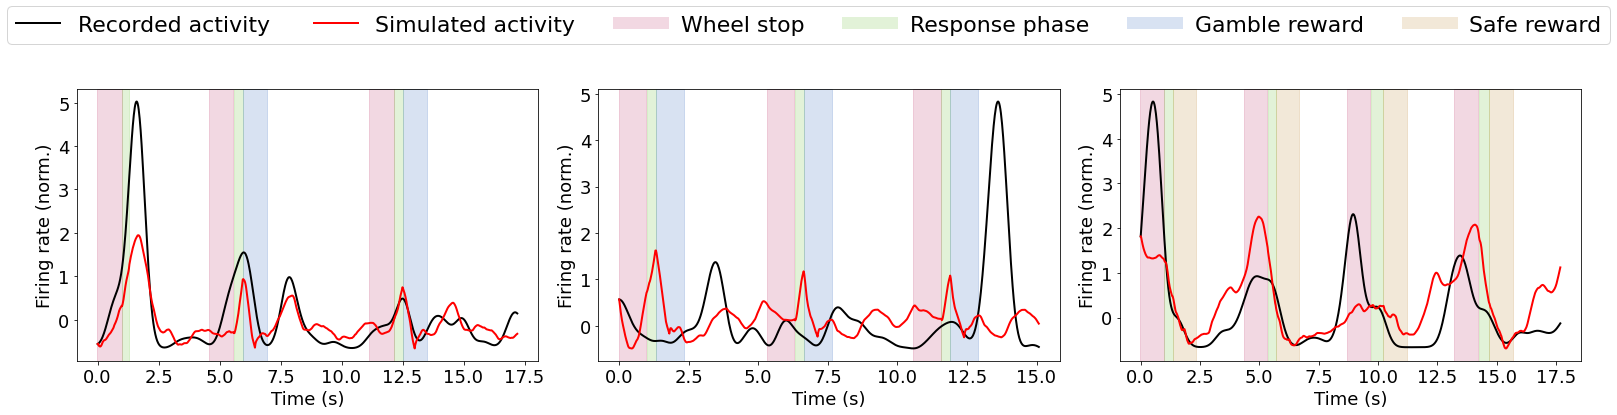

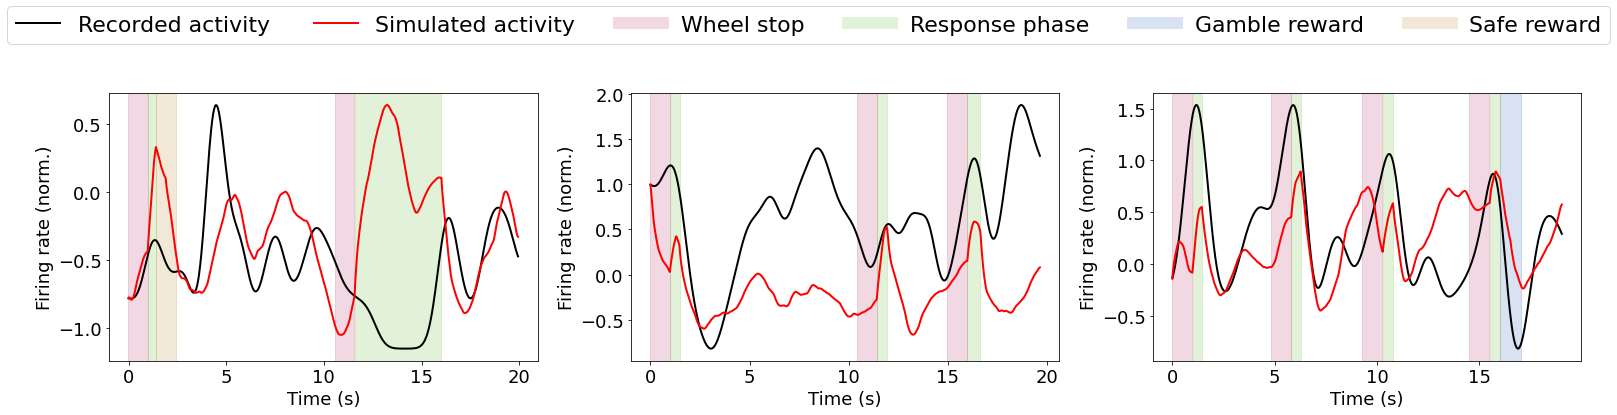

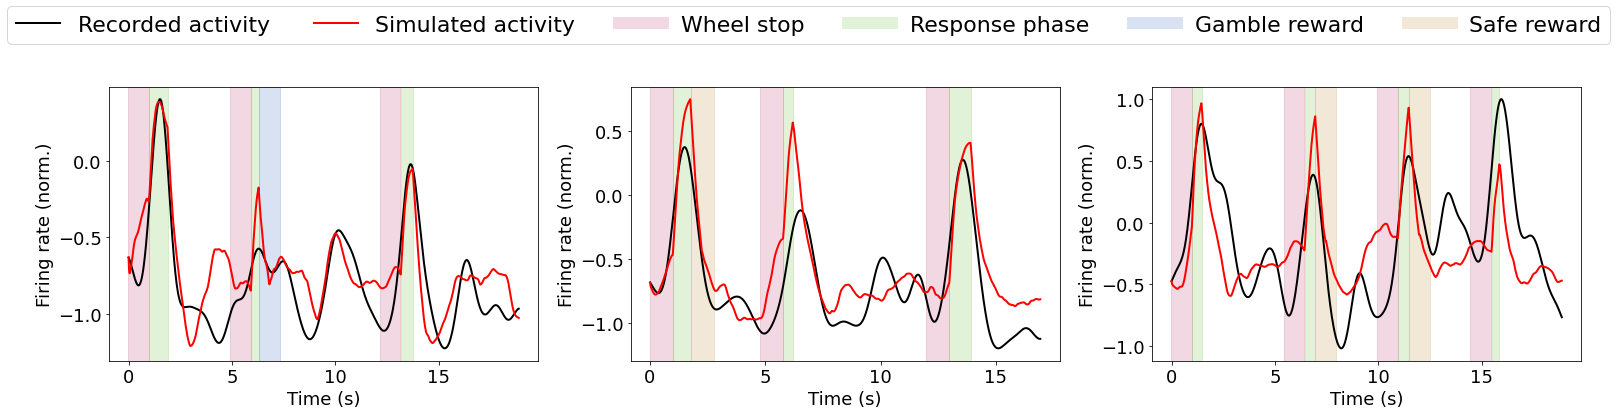

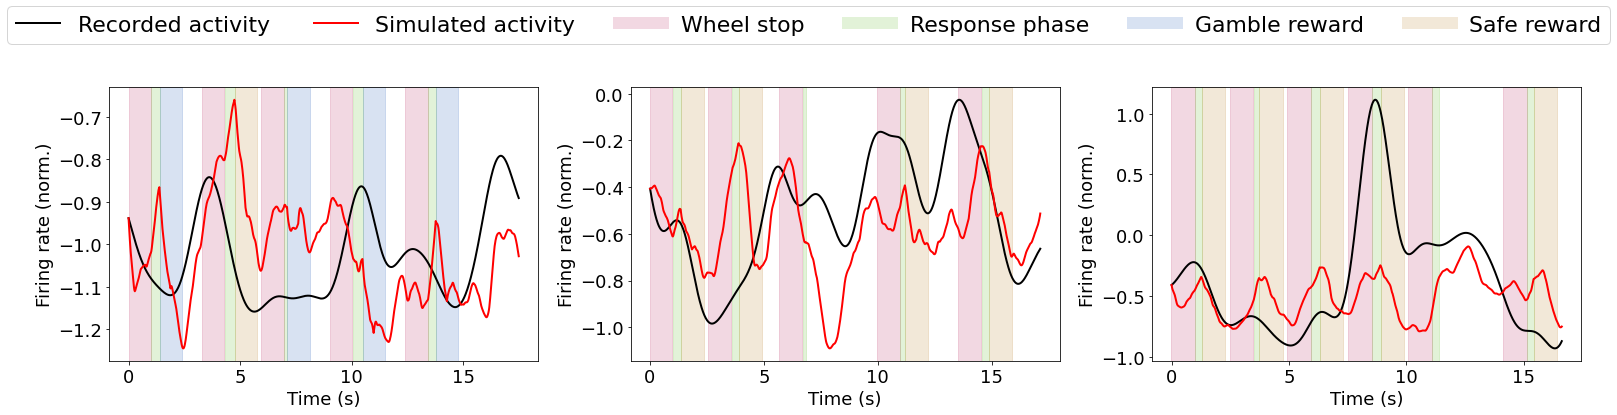

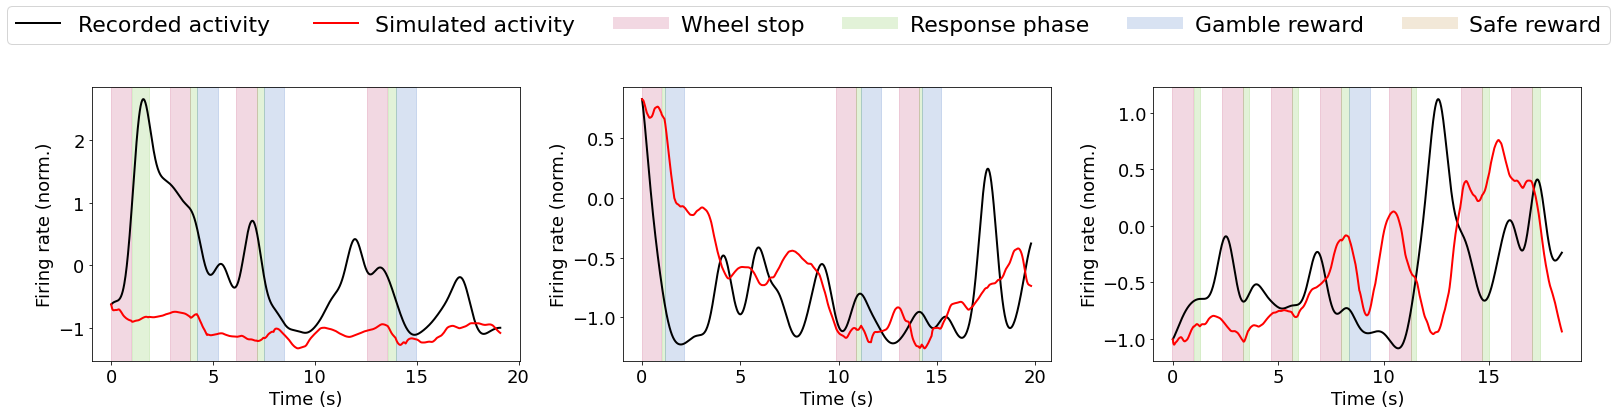

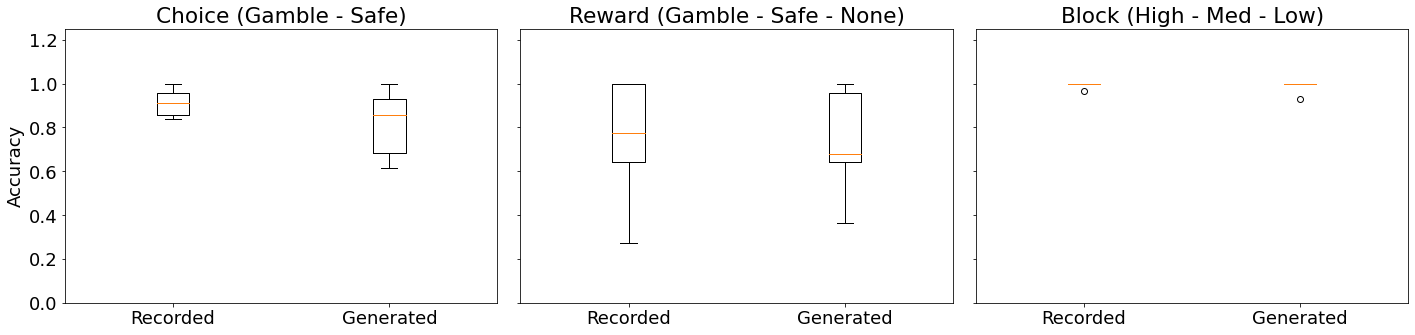

In [4]:
num_sessions = len(mod_sessions)
last_epoch = 150000
Choice_rec = [] ; Choice_gen =[]
Reward_rec = [] ; Reward_gen =[]
Block_rec = [] ; Block_gen =[]


for isess in range(num_sessions):
    Neural_path = os.path.join(path_models,mod_sessions[isess],extra_activity)
    Model_path = os.path.join(path_models,mod_sessions[isess],extra_models).replace('\\','/')
    Behavioural_path = os.path.join(path_behaviours,rec_sessions[isess]).replace('\\','/')
    Hyper_mod(Model_path,Neural_path)
    C_data,C_model,R_data,R_model,B_data,B_model = Classifier_Test_Sessions(Neural_path,Model_path,Behavioural_path,last_epoch)
    Choice_rec.append(C_data) ; Choice_gen.append(C_model)
    Reward_rec.append(R_data) ; Reward_gen.append(R_model)
    Block_rec.append(B_data) ; Block_gen.append(B_model)

fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
Models = ['Recorded','Generated']
axs[0].boxplot([Choice_rec,Choice_gen],labels=Models)
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Choice (Gamble - Safe)')
axs[0].set_ylim([0,1.25])
axs[1].boxplot([Reward_rec,Reward_gen],labels=Models)
axs[1].set_title('Reward (Gamble - Safe - None)')
axs[2].boxplot([Block_rec,Block_gen],labels=Models)
axs[2].set_title('Block (High - Med - Low)')
plt.tight_layout()
plt.show()